In [2]:
# Import libraries to use 
import numpy as np
import matplotlib.pyplot as plt
import math       
import scipy as sp
import scipy.optimize
import subprocess # Library to run ngspice on shell
import seaborn as sns # Library to change the color palette for plots
import random
import timeit # To time computing time
import warnings # To supress warnings
import string

import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
axis_font = {'size':'14'}

In this notebook we are going to addapt the model that we have previously develop to describe a stack of tapes considering contact in between. This model can expand in number of tapes and number or sections. 
(See the notebook Multiple tapes with contact in the contact resistance folder).

This time we will include an inductance next to each voltage source, that means that if we have a number of sections "ns" we will also have the same number of inductors per tape.

### This notebook is similar to the one called "Stack of tapes with inductances", but in this case we will not consider uniform tapes.

In [3]:
# Definition to generate netlist for an arbitraty number of sections and arbitrary number of tapes
# In this case we can vary the Ic value and the Rc resistances, n remains constant equal to 30

def generatingnetlist(filename,ns,ntapes,length,Rt,Ic,n,Rc,L,Imax,t_rise): # Inputs
    
    nodes = (((2*ns)+1)*ntapes)+1 # Number of nodes
    
    # Printing the labels of the elements to read current for this case
    Labels = ['Index','time']
    
    # Voltage in nodes
    for i in range(nodes):
        Labels.append(f'v({i+1})')
    # Contact resistances
    for i in range(ntapes-1):
            for j in range(ns+1):
                Labels.append(f'@r_{i+1}_{j+1}[i]')
    # Voltage sources
    for i in range(ntapes):
        for j in range(ns):
            Labels.append(f'@b_{i+1}_{j+1}[i]')
    
    # Inductances
    for i in range(ntapes):
            for j in range(ns):
                Labels.append(f'@l_{i+1}_{j+1}[i]')
    # Terminal resistances
    for i in range(ntapes):
            Labels.append(f'@rt_i_{i+1}[i]')
            
    probe = ''
    for i in range(len(Labels)-2):
        probe = probe + Labels[i+2]+' '
    #print(probe)
    
    # Constant Parameters for the model
    #Rt = 5E-7 # [Ohm]Terminal resistance
    #n = 30 # n-value
    Ec = 100E-6 # Electric field criterion
    #length = 1 # [m] length of tape
    Vc = Ec*length # Voltage criterion
    #Imax = 250 # Maximum current
    
    #t_rise = 0.2 # [s]
    t_fall = 0.2
    t_on = 10
    t_tot = 30
    
    step = 0.01 # Step current
    #Data_points = int(t_tot/step + 1) # Data points calculated directly 
    #Data_points = 75
    # Start writing netlist
    with open(filename, 'w') as output:
        output.write(f'* Netlist for 2 tapes with contact resistance\n')
        #output.write('I1 0 1 100\n') # Current source DC
        output.write(f'I1 0 1 PULSE(0 {Imax} 0 {t_rise} {t_fall} {t_on})\n') # Pulse I_start I_max t_delay t_rise t_fall t_on
        
        output.write('.option rser = 0\n')
        
        # Terminal resistances
        for i in range(ntapes):
            output.write(f'rt_i_{i+1} 1 {2+(2*ns+1)*i} {Rt}\n')
            output.write(f'rt_f_{i+1} {((2*ns+1)*(i+1))+1} 0 {Rt}\n')
            
        # Contact resistances
        for i in range(ntapes-1):
            for j in range(ns+1):
                output.write(f'r_{i+1}_{j+1} {2+(2*ns+1)*(i+1)+j*2} {2+(2*ns+1)*i+j*2} {Rc[i,j]}\n')

        # Voltage sources
        for i in range(ntapes):
            for j in range(ns):
                output.write(f'b_{i+1}_{j+1} {2+(2*ns+1)*i+j*2} {3+(2*ns+1)*i+j*2} V={Vc/ns}*pow((I(b_{i+1}_{j+1})/{Ic[i,j]}),{n})\n')
        
        # Indutances 
        for i in range(ntapes):
            for j in range(ns):
                output.write(f'l_{i+1}_{j+1} {3+(2*ns+1)*i+j*2} {4+(2*ns+1)*i+j*2} {L[i,j]}\n')
                
        output.write('.options savecurrents\n')
        #output.write(f'.dc I1 0 {Imax} 1\n')
        output.write(f'.tran {step} {t_tot}\n')
        output.write('.print tran '+probe+'\n')
        output.write('.end\n')
    return Labels
        

In [4]:
# This definition is used to run the netlist in ngspice and load the data generated by the program. 

def readdata(filename,Labels):
    out = subprocess.run(['ngspice', '-b', filename], 
                         stdout=subprocess.PIPE,  stderr=subprocess.PIPE)
    
    name = filename[:-4]+'.txt' # Name of the file to save output from ngspice
    
    # This saves output data in txt file
    with open(name, 'w') as output:
        for line in out.stdout.decode('ascii').split('\n'):
            output.write(line+'\n') # Writing output lines 
    
    # We get the data into an array 
    fill = np.zeros (len(Labels), dtype=int)
    
    f = open (name, 'r');
    src = []
    while True:  
        line = f.readline()
        if not line: break  # end of file
        if line[0] == '#':
            continue # treat next line
        src.append(line)

    #print(src)
    #data = np.zeros ([Data_points, len(Labels)])
    
    flag = False
    for line in src:
        #print line
        # Here we initialize the ngspice data array
        
        if line.startswith('No.'):
            temp_list = line.split(":")
            Data_points = int(temp_list[-1])
            #print(Data_points)
            data = np.zeros ([Data_points, len(Labels)])
            #print(data.shape)
        
        
        
        # Here we determine the indexes for the current columns
        if line.startswith('Index'):
            flag = True
            temp_list = [str(x) for x in line.split()]
            #print(temp_list)
            n_columns = len(temp_list)
            #print('n_columns\n',n_columns)
            index = np.zeros(n_columns, dtype = int)

            for j in range(n_columns):
                index [j] = Labels.index(temp_list[j])
            #print index

        # if the line starts with a number, we treat it as the data line
        if flag == True: # Only if the first index has passed for the ac analysis
            if line[0].isdigit():
                temp_data = [float(x) for x in line.split()]

                for c in range(n_columns):
                    r = fill[c]
                    #print(r, index [c])

                    data [r][index[c]] = temp_data [c]

                    fill [c] = fill [c] + 1
                    if fill [c] == Data_points:
                        fill [c] = 0
    return data

# Low Rc for 2 tapes with different Ic

- The length of the tape that we are considering is 1 m. 
- With the model we can divide the tape in several sectiond but we are only considering 1 section in this case. 

### The first case that we consider is 2 tapes of only one section
<img src="schematic2tapes.jpg">

- The voltage was limited to the order of microV by choosing a maximum cable current of 150 A for 2 tapes. 
- We also changed the rise time of the fuction that defines the current source $I_{cable}$, in this case is 0.15 s, which gives a ramp rate of 1 kA/s.
- We zoom in to the first 0.5 s where we can observe the impact of the inductance during the ramp up.
#### The Ic for each tape is different, 100 A for tape 1 and 50 A for tape 2.


# Impact of the inductance


- We compare two values of L: 57 nH and 0 H.
- Both cases have low Rc of 10 nOhms and Rt of 250 nOhms.


Rc [[1.e-08 1.e-08]]
Ic [[100.]
 [ 50.]]
L [[5.7e-08]
 [5.7e-08]]
Imax = 150


<IPython.core.display.Javascript object>


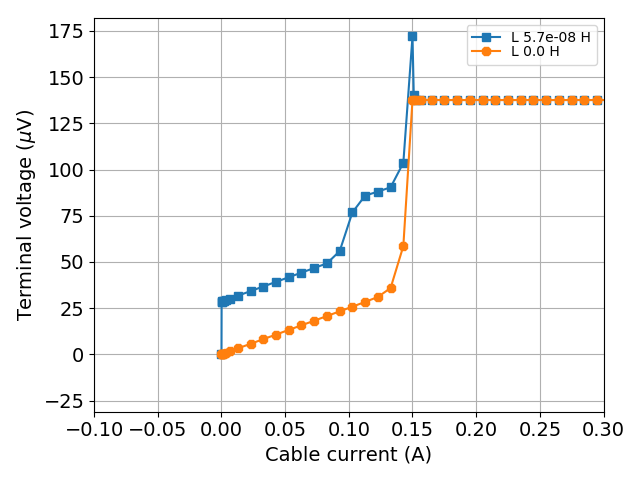

Rc [[1.e-08 1.e-08]]
Ic [[100.]
 [ 50.]]
L [[0.]
 [0.]]
Imax = 150


In [5]:
%matplotlib notebook
L_val = [57E-9,0]
markers = ["s","8","p","*","3",".","x","1","+"]
for i in range(len(L_val)):
    ns = 1
    ntapes = 2
    filename = 'multipletapes_withL_lowRc.cir'
    
    Rt = 250E-9 # [Ohm] Terminal resistance
    n = 30 # n-value
    length = 1 # [m] length of tape

    Rc_mean = 10E-9 # [Ohms] This value should be less than 0.4 times Rt (for the case of low resistance)
    Ic_mean = 100 # [Amps]
    L_mean = L_val[i]*length/ns # [Henries]

    Rc = np.zeros((ntapes-1,ns+1))+Rc_mean
    print('Rc',Rc)

    Ic = np.zeros((ntapes,ns))+Ic_mean
    Ic[1,0]=50
    print('Ic',Ic)

    L = np.zeros((ntapes,ns))+L_mean
    print('L',L)

    #Imax = ntapes*Ic_mean*1.25
    Imax = 150
    print(f'Imax = {Imax}')
    
    t_rise = 0.15
    # Generating netlist
    Labels = generatingnetlist(filename,ns,ntapes,length,Rt,Ic,n,Rc,L,Imax,t_rise)

    # Running ngspice and saving data to notebook
    data = readdata(filename,Labels)

    plt.plot(data[:,1],data[:,2]/1e-6,marker=markers[i],label = f'L {L_mean} H')
plt.xlabel('Cable current (A)',**axis_font)
plt.ylabel('Terminal voltage ($\mu$V)',**axis_font)
plt.xlim(-0.1,0.3)
plt.legend(labelspacing=0.001,ncol=1,loc='best',prop={'size': 10})
plt.tight_layout()
plt.grid()
plt.savefig('Plot/Inductance_lowRc_tapes-charg.png',dpi=300)

Rc [[1.e-08 1.e-08]]
Ic [[100.]
 [ 50.]]
L [[5.7e-08]
 [5.7e-08]]
Imax = 150


<IPython.core.display.Javascript object>


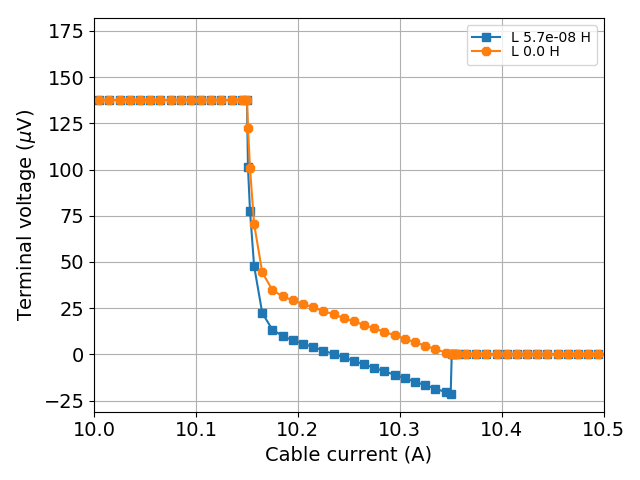

Rc [[1.e-08 1.e-08]]
Ic [[100.]
 [ 50.]]
L [[0.]
 [0.]]
Imax = 150


In [8]:
%matplotlib notebook
L_val = [57E-9,0]
markers = ["s","8","p","*","3",".","x","1","+"]
for i in range(len(L_val)):
    ns = 1
    ntapes = 2
    filename = 'multipletapes_withL_lowRc.cir'
    
    Rt = 250E-9 # [Ohm] Terminal resistance
    n = 30 # n-value
    length = 1 # [m] length of tape

    Rc_mean = 10E-9 # [Ohms] This value should be less than 0.4 times Rt (for the case of low resistance)
    Ic_mean = 100 # [Amps]
    L_mean = L_val[i]*length/ns # [Henries]

    Rc = np.zeros((ntapes-1,ns+1))+Rc_mean
    print('Rc',Rc)

    Ic = np.zeros((ntapes,ns))+Ic_mean
    Ic[1,0]=50
    print('Ic',Ic)

    L = np.zeros((ntapes,ns))+L_mean
    print('L',L)

    #Imax = ntapes*Ic_mean*1.25
    Imax = 150
    print(f'Imax = {Imax}')
    
    t_rise = 0.15
    # Generating netlist
    Labels = generatingnetlist(filename,ns,ntapes,length,Rt,Ic,n,Rc,L,Imax,t_rise)

    # Running ngspice and saving data to notebook
    data = readdata(filename,Labels)

    plt.plot(data[:,1],data[:,2]/1e-6,marker=markers[i],label = f'L {L_mean} H')
plt.xlabel('Cable current (A)',**axis_font)
plt.ylabel('Terminal voltage ($\mu$V)',**axis_font)
plt.xlim(10,10.5)
plt.legend(labelspacing=0.001,ncol=1,loc='best',prop={'size': 10})
plt.tight_layout()
plt.grid()
plt.savefig('Plot/Inductance_lowRc_tapes-charg.png',dpi=300)

# Distribution of currents for low Rc with L = 57 nH


Rc [[1.e-08 1.e-08]]
Ic [[100.]
 [ 50.]]
L [[5.7e-08]
 [5.7e-08]]
Imax = 150


<IPython.core.display.Javascript object>


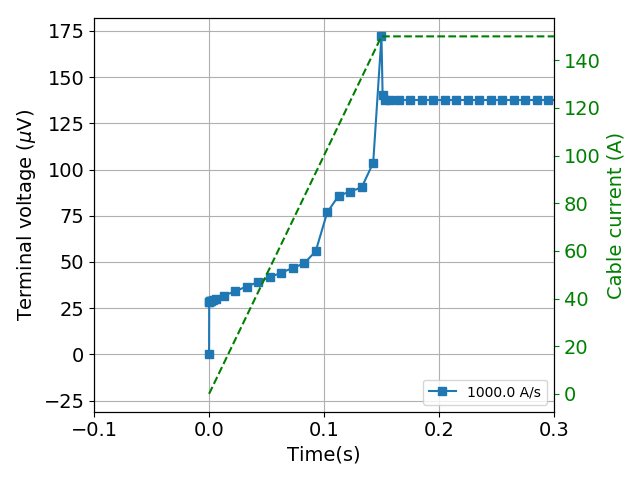

<IPython.core.display.Javascript object>


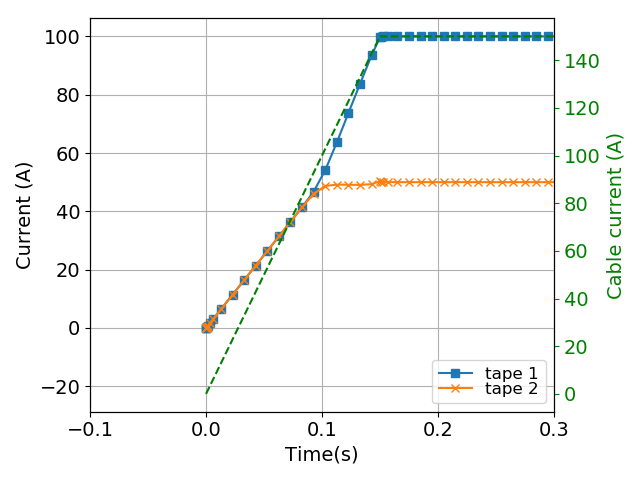

<IPython.core.display.Javascript object>


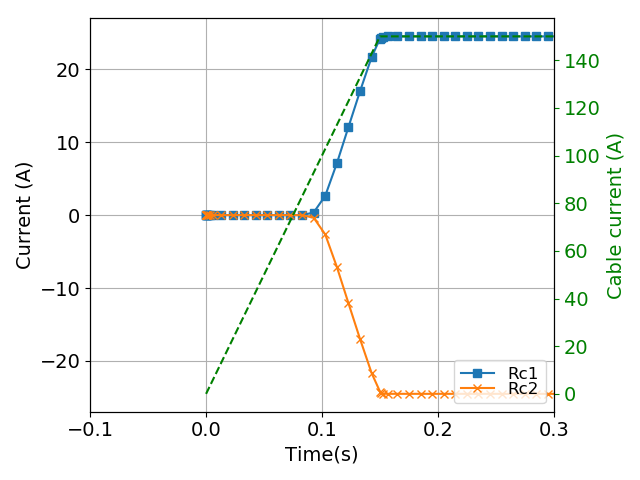

In [10]:
# Here we define all the inputs that are needed to generate the netlist
%matplotlib notebook

filename = 'multipletapes_withL_lowRc.cir'
ntapes = 2
ns = 1

Rt = 250E-9 # [Ohm] Terminal resistance
n = 30 # n-value
length = 1 # [m] length of tape

Rc_mean = 10E-9 # [Ohms] This value should be less than 0.4 times Rt (for the case of low resistance)
Ic_mean = 100 # [Amps]
L_mean = 57E-9*length/ns # [Henries]
#L_mean = 0.1E-6
Rc = np.zeros((ntapes-1,ns+1))+Rc_mean
print('Rc',Rc)

Ic = np.zeros((ntapes,ns))+Ic_mean
Ic[1,0]=50
print('Ic',Ic)

L = np.zeros((ntapes,ns))+L_mean
print('L',L)

#Imax = ntapes*Ic_mean*1.25
Imax = 150
print(f'Imax = {Imax}')
t_rise = 0.15

# Generating netlist
Labels = generatingnetlist(filename,ns,ntapes,length,Rt,Ic,n,Rc,L,Imax,t_rise)

# Running ngspice and saving data to notebook
data = readdata(filename,Labels)
time= data[:,1]
Icable = data[:,15]+data[:,16]

fig, ax = plt.subplots()
ax.plot(time,data[:,2]/1E-6,marker = 's',label= f'{Imax/t_rise} A/s')
ax.set_ylabel('Terminal voltage ($\mu$V)',**axis_font)
ax.set_xlabel('Time(s)',**axis_font)
ax.legend(loc='lower right')
ax.grid()
ax.set_xlim(-0.1,0.3)

ax2 = ax.twinx()
ax2.plot(time,Icable,'--g')
ax2.set_ylabel('Cable current (A)',color = 'g',**axis_font)
ax2.tick_params(axis='y', colors='g')

#ax.set_ylim(0,100E-6)
plt.tight_layout()
plt.savefig('Plot/Inductance_lowRc.png',dpi=300)
plt.show()
#print(Labels)

# Current in the voltage sources

index1 = 11#16
index2 = 12#18
fig,ax = plt.subplots()

ax.plot(data[:,1],data[:,index1],marker = 's',label=f'tape 1')
ax.plot(data[:,1],data[:,index2],marker='x',label=f'tape 2')
ax.set_ylabel('Current (A)',**axis_font)
ax.set_xlabel('Time(s)',**axis_font)
ax.grid()
ax.legend(labelspacing=0.001,loc='lower right',prop={'size': 12})
ax.set_xlim(-0.1,0.3)

ax2 = ax.twinx()
ax2.plot(time,Icable,'--g')
ax2.set_ylabel('Cable current (A)',color = 'g',**axis_font)
ax2.tick_params(axis='y', colors='g')

plt.tight_layout()
plt.savefig('Plot/Tape_lowRc-2tapes.png',dpi=300)
plt.show()

# Current in the voltage sources

index1 = 9#16
index2 = 10#18
fig,ax = plt.subplots()

ax.plot(data[:,1],data[:,index1],marker = 's',label=f'Rc1')
ax.plot(data[:,1],data[:,index2],marker='x',label=f'Rc2')
ax.set_ylabel('Current (A)',**axis_font)
ax.set_xlabel('Time(s)',**axis_font)
ax.grid()
ax.legend(labelspacing=0.001,loc='lower right',prop={'size': 12})
ax.set_xlim(-0.1,0.3)

ax2 = ax.twinx()
ax2.plot(time,Icable,'--g')
ax2.set_ylabel('Cable current (A)',color = 'g',**axis_font)
ax2.tick_params(axis='y', colors='g')

plt.tight_layout()
plt.savefig('Plot/Rc_lowRc-2tapes.png',dpi=300)
plt.show()

### Notes

- The current in the voltage sources is even until the cable current reaches a value close to 80 A. After that a higher amount of current flows through the tape 1 (Ic = 100 A), limiting the current through tape 2.
- In the case of the current flowing through Rc 1 and 2, the current are zero before the cable currents reaches a value of 80 A. After that the current increases and keeps constant in both cases when $I_{cable}$ is constant.

# Lets analyse how the ramp rate affects the terminal voltage

- In all these cases the maximum cable current is 150 A, but various t_rise are used in order to have different current rates during charging. 

Imax = 150


<IPython.core.display.Javascript object>


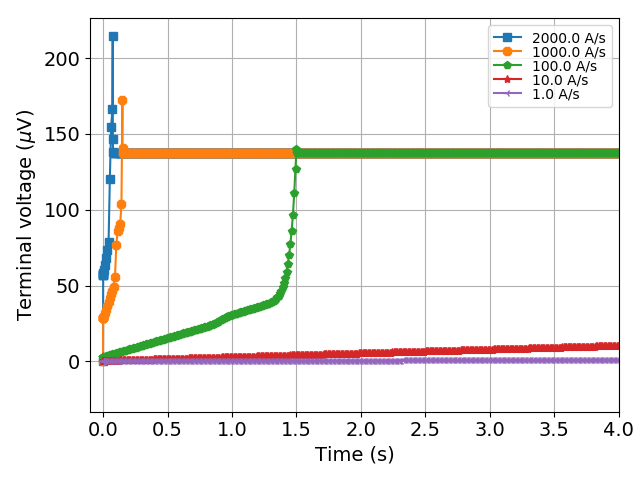

Imax = 150
Imax = 150
Imax = 150
Imax = 150


In [15]:
%matplotlib notebook
t_rise_val = [0.075, 0.15,1.5,15,150]
markers = ["s","8","p","*","3",".","x","1","+"]
for i in range(len(t_rise_val)):
    ns = 1
    ntapes = 2
    filename = 'multipletapes_withL_lowRc.cir'
    
    Rt = 250E-9 # [Ohm] Terminal resistance
    n = 30 # n-value
    length = 1 # [m] length of tape

    Rc_mean = 10E-9 # [Ohms] This value should be less than 0.4 times Rt (for the case of low resistance)
    Ic_mean = 100 # [Amps]
    L_mean = 57E-9*length/ns # [Henries]

    Rc = np.zeros((ntapes-1,ns+1))+Rc_mean
    #print('Rc',Rc)

    Ic = np.zeros((ntapes,ns))+Ic_mean
    Ic[1,0]=50
    #print('Ic',Ic)

    L = np.zeros((ntapes,ns))+L_mean
    #print('L',L)

    #Imax = ntapes*Ic_mean*1.25
    Imax = 150
    print(f'Imax = {Imax}')
    
    t_rise = t_rise_val[i]
    # Generating netlist
    Labels = generatingnetlist(filename,ns,ntapes,length,Rt,Ic,n,Rc,L,Imax,t_rise)

    # Running ngspice and saving data to notebook
    data = readdata(filename,Labels)

    plt.plot(data[:,1],data[:,2]/1E-6, marker = markers[i],label = f'{Imax/t_rise} A/s')
plt.xlim(-0.1,4)
plt.xlabel('Time (s)',**axis_font)
plt.ylabel('Terminal voltage ($\mu$V)',**axis_font)
plt.legend(labelspacing=0.001,ncol=1,loc='best',prop={'size': 10})
plt.tight_layout()
plt.grid()
plt.savefig('Plot/Inductance_lowRc_tapes_rate.png',dpi=300)
plt.show()



Imax = 150


<IPython.core.display.Javascript object>


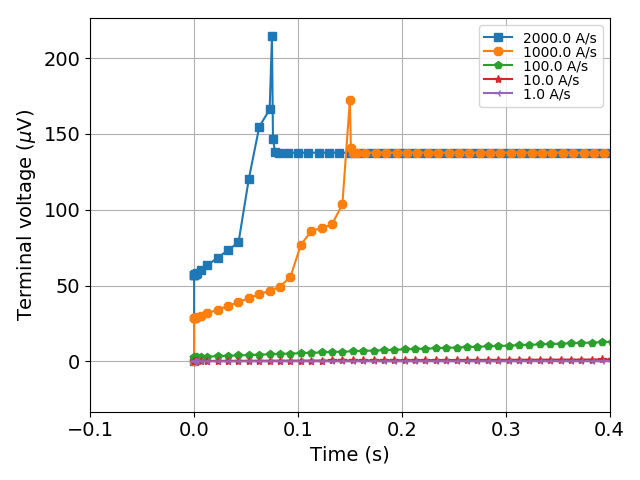

Imax = 150
Imax = 150
Imax = 150
Imax = 150


In [14]:
## Zoom in

%matplotlib notebook
t_rise_val = [0.075, 0.15,1.5,15,150]
markers = ["s","8","p","*","3",".","x","1","+"]
for i in range(len(t_rise_val)):
    ns = 1
    ntapes = 2
    filename = 'multipletapes_withL_lowRc.cir'
    
    Rt = 250E-9 # [Ohm] Terminal resistance
    n = 30 # n-value
    length = 1 # [m] length of tape

    Rc_mean = 10E-9 # [Ohms] This value should be less than 0.4 times Rt (for the case of low resistance)
    Ic_mean = 100 # [Amps]
    L_mean = 57E-9*length/ns # [Henries]

    Rc = np.zeros((ntapes-1,ns+1))+Rc_mean
    #print('Rc',Rc)

    Ic = np.zeros((ntapes,ns))+Ic_mean
    Ic[1,0]=50
    #print('Ic',Ic)

    L = np.zeros((ntapes,ns))+L_mean
    #print('L',L)

    #Imax = ntapes*Ic_mean*1.25
    Imax = 150
    print(f'Imax = {Imax}')
    
    t_rise = t_rise_val[i]
    # Generating netlist
    Labels = generatingnetlist(filename,ns,ntapes,length,Rt,Ic,n,Rc,L,Imax,t_rise)

    # Running ngspice and saving data to notebook
    data = readdata(filename,Labels)

    plt.plot(data[:,1],data[:,2]/1E-6, marker = markers[i],label = f'{Imax/t_rise} A/s')
plt.xlim(-0.1,0.4)
plt.xlabel('Time (s)',**axis_font)
plt.ylabel('Terminal voltage ($\mu$V)',**axis_font)
plt.legend(labelspacing=0.001,ncol=1,loc='best',prop={'size': 10})
plt.tight_layout()
plt.grid()
plt.savefig('Plot/Inductance_lowRc_tapes_ratezoom.png',dpi=300)
plt.show()

## Notes
- As the ramp rate increases we observed a higher terminal voltage before the current changes to be constant.
- The voltage profiles are less smooth than in the case of uniform tapes, caused by the redistribution of the current when aproaching the critical current value of the cable. 



# Results for high Rc in 2 tapes with only one section

- All the parameters for the model are the same to the previous cases except Rc, in this case we used 1000 Ohms.

Rc [[1000. 1000.]]
Ic [[100.]
 [ 50.]]
L [[5.7e-08]
 [5.7e-08]]
Imax = 150


<IPython.core.display.Javascript object>


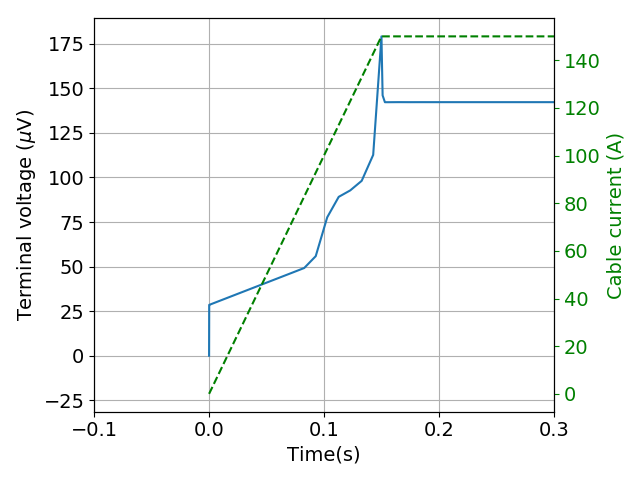

<IPython.core.display.Javascript object>


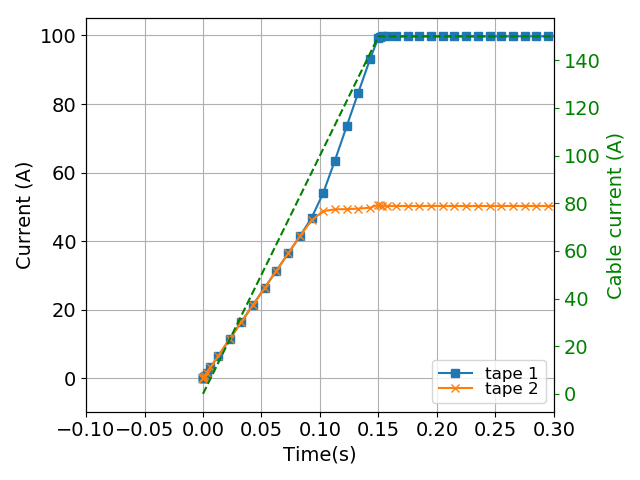

<IPython.core.display.Javascript object>


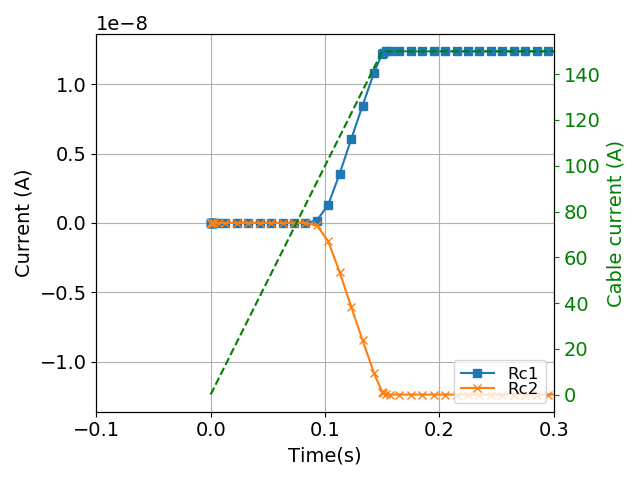

In [16]:
# Here we define all the inputs that are needed to generate the netlist
%matplotlib notebook

filename = 'multipletapes_withL_highRc.cir'
ntapes = 2
ns = 1

Rt = 250E-9 # [Ohm] Terminal resistance
n = 30 # n-value
length = 1 # [m] length of tape

Rc_mean = 1000 # [Ohms] This value should be less than 0.4 times Rt (for the case of low resistance)
Ic_mean = 100 # [Amps]
L_mean = 57E-9*length/ns # [Henries]

Rc = np.zeros((ntapes-1,ns+1))+Rc_mean
print('Rc',Rc)

Ic = np.zeros((ntapes,ns))+Ic_mean
Ic[1,0]=50
print('Ic',Ic)

L = np.zeros((ntapes,ns))+L_mean
print('L',L)

#Imax = ntapes*Ic_mean*1.25
Imax = 150
print(f'Imax = {Imax}')

t_rise =0.15

# Generating netlist
Labels = generatingnetlist(filename,ns,ntapes,length,Rt,Ic,n,Rc,L,Imax,t_rise)

# Running ngspice and saving data to notebook
data = readdata(filename,Labels)
time= data[:,1]
Icable = data[:,15]+data[:,16]

fig, ax = plt.subplots()
ax.plot(time,data[:,2]/1e-6)
ax.set_ylabel('Terminal voltage ($\mu$V)',**axis_font)
ax.set_xlabel('Time(s)',**axis_font)
ax.set_xlim(-0.1,0.3)
ax.grid()

ax2 = ax.twinx()
ax2.plot(time,Icable,'--g')
ax2.set_ylabel('Cable current (A)',color = 'g',**axis_font)
ax2.tick_params(axis='y', colors='g')

plt.tight_layout()
plt.savefig('Plot/Inductance_highRc.png',dpi=300)
plt.show()


# Current in the voltage sources

index1 = 11#16
index2 = 12#18
fig,ax = plt.subplots()

ax.plot(data[:,1],data[:,index1],marker = 's',label=f'tape 1')
ax.plot(data[:,1],data[:,index2],marker='x',label=f'tape 2')
ax.set_ylabel('Current (A)',**axis_font)
ax.set_xlabel('Time(s)',**axis_font)
ax.set_xlim(-0.1,0.3)
ax.grid()
ax.legend(labelspacing=0.001,loc='lower right',prop={'size': 12})

ax2 = ax.twinx()
ax2.plot(time,Icable,'--g')
ax2.set_ylabel('Cable current (A)',color = 'g',**axis_font)
ax2.tick_params(axis='y', colors='g')

plt.tight_layout()
plt.savefig('Plot/Tape_hRc-2tapes.png',dpi=300)
plt.show()


# Current in the voltage sources

index1 = 9#16
index2 = 10#18
fig,ax = plt.subplots()

ax.plot(data[:,1],data[:,index1],marker = 's',label=f'Rc1')
ax.plot(data[:,1],data[:,index2],marker='x',label=f'Rc2')
ax.set_ylabel('Current (A)',**axis_font)
ax.set_xlabel('Time(s)',**axis_font)
ax.set_xlim(-0.1,0.3)
ax.grid()
ax.legend(labelspacing=0.001,loc='lower right',prop={'size': 12})

ax2 = ax.twinx()
ax2.plot(time,Icable,'--g')
ax2.set_ylabel('Cable current (A)',color = 'g',**axis_font)
ax2.tick_params(axis='y', colors='g')

plt.tight_layout()
plt.savefig('Plot/Rc_hRc-2tapes.png',dpi=300)
plt.show()

## Notes

- At first glance the terminal voltage and the current distribution through the tapes looks similar to the case of low Rc.
- The current through the contact resistances in the case of high Rc is lower compared to the case of high Rc.